***
*Course:* [Math 535](http://www.math.wisc.edu/~roch/mmids/) - Mathematical Methods in Data Science (MMiDS)  
*Author:* [Sebastien Roch](http://www.math.wisc.edu/~roch/), Department of Mathematics, University of Wisconsin-Madison  
***

# <span style="background-color:dodgerblue; color:white; padding:2px 6px">APPLICATIONS</span> 
# $k$-means clustering


*Updated:* March 20, 2020  

*Julia version:* 1.3.1

## Contents

[Recap from the lectures](#Recap-from-the-lectures)

1 [Species delimitation](#1-Species-delimitation)

2 [Document topic discovery](#2-Document-topic-discovery)

3 [Using JuliaStats/Clustering.jl](#3-Using-JuliaStats/Clustering.jl)

In [1]:
using CSV, DataFrames, Plots, LinearAlgebra

## Recap from the lectures

***The setup*** We are given $n$ vectors $\mathbf{x}_1,\ldots,\mathbf{x}_n$ in $\mathbb{R}^d$. Our goal is to find a good <a href="https://en.wikipedia.org/wiki/Cluster_analysis">clustering</a>: loosely speaking, we want to partition these data points into $k$ disjoint subsets -- or clusters -- with small pairwise distances within clusters and large pairwise distances across clusters. To make this rather imprecise problem more precise, we consider a specific objective function known as the $k$-means objective. 

Fix a number of clusters $k$. A partition of $[n] = \{1,\ldots,n\}$ of size $k$ is a collection of disjoint non-empty subsets $C_1,\ldots,C_k \subseteq [n]$ that covers all of $[n]$, that is, such that $\cup_{i=1}^k C_i = [n]$. The cost of $C_1,\ldots,C_k$ is then defined as

$$
\mathcal{G}(C_1,\ldots,C_k) = \min_{\boldsymbol{\mu}_1,\ldots,\boldsymbol{\mu}_k} \sum_{i=1}^k \sum_{j \in C_i} \|\mathbf{x}_j - \boldsymbol{\mu}_i\|^2.
$$

We think of $\boldsymbol{\mu}_i$ as the representative -- or center -- of cluster $C_i$. Note that $\boldsymbol{\mu}_i$ need not be one of the $\mathbf{x}_j$'s. Our goal is to find a partition that minimizes $\mathcal{G}(C_1,\ldots,C_k)$. 

The $k$-means algorithm is a popular heuristic. It is based on the idea that the following two sub-problems are easy to solve: 

1. finding the optimal representatives for a fixed partition
2. finding the optimal partition for a fixed set of representatives.

One then alternates between the two.

***The theory*** We proved the following.

<b>Lemma (Optimal Representatives):</b> Fix a partition $C_1,\ldots,C_k$. The optimal representatives are the centroids

$$
\boldsymbol{\mu}_i^* = \frac{1}{|C_i|} \sum_{j\in C_i} \mathbf{x}_j.
$$

<b>Lemma (Optimal Clustering):</b> Fix the representatives $\boldsymbol{\mu}_1,\ldots,\boldsymbol{\mu}_k$. An optimal partition is obtained as follows. For each $j$, find the $\boldsymbol{\mu}_i$ that minimizes $\|\mathbf{x}_j - \boldsymbol{\mu}_i\|^2$ (picking one arbitrarily in the case of ties) and assign $\mathbf{x}_j$ to $C_i$. 

**Theorem (Convergence of $k$-means):** The sequence of objective function values produced by the $k$-means algorithm is non-increasing.

***The algorithm***

In [2]:
function opt_clust(X, k, reps)
    n, d = size(X) # n=number of rows, d=number of columns 
    dist = zeros(Float64, n) # distance to rep
    assign = zeros(Int64, n) # cluster assignments
    for i = 1:n
        dist[i], assign[i] = findmin([norm(X[i,:] .- reps[j,:]) for j=1:k])
    end
    @show G = sum(dist.^2)
    return assign
end

opt_clust (generic function with 1 method)

In [3]:
function opt_reps(X, k, assign)
    n, d = size(X)
    reps = zeros(Float64, k, d) # rows are representatives
    for j = 1:k
        in_j = [i for i=1:n if assign[i] == j]             
        reps[j,:] = sum(X[in_j,:],dims=1) ./ length(in_j)
    end
    return reps
end

opt_reps (generic function with 1 method)

In [4]:
function mmids_kmeans(X, k; maxiter=10)
    n, d = size(X)
    assign = [rand(1:k) for i in 1:n] # start with random assignments
    reps = zeros(Int64, k, d) # initialization of reps
    for iter = 1:maxiter
        # Step 1: Optimal representatives for fixed clusters
        reps = opt_reps(X, k, assign) 
        # Step 2: Optimal clusters for fixed representatives
        assign = opt_clust(X, k, reps)     
    end
    return assign
end

mmids_kmeans (generic function with 1 method)

## 1 Species delimitation

We will look again at the [classical iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set) first analyzed by Fisher. We will upload the data in the form of a `DataFrame` -- similar to a spreadsheet -- where the columns are different measurements (or features) and the rows are different samples.

In [5]:
df = CSV.read("./iris-measurements.csv")
first(df, 5)

,Id,PetalLengthCm,PetalWidthCm,SepalLengthCm,SepalWidthCm
,Int64,Float64,Float64,Float64,Float64
1,1,1.4,0.2,5.1,3.5
2,2,1.4,0.2,4.9,3.0
3,3,1.3,0.2,4.7,3.2
4,4,1.5,0.2,4.6,3.1
5,5,1.4,0.2,5.0,3.6


In [6]:
describe(df)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,Id,75.5,1,75.5,150,,,Int64
2,PetalLengthCm,3.75867,1.0,4.35,6.9,,,Float64
3,PetalWidthCm,1.19867,0.1,1.3,2.5,,,Float64
4,SepalLengthCm,5.84333,4.3,5.8,7.9,,,Float64
5,SepalWidthCm,3.054,2.0,3.0,4.4,,,Float64


Let's first extract the columns and combine them into a data matrix `X`, and visualize the $2$-dimensional petal data.

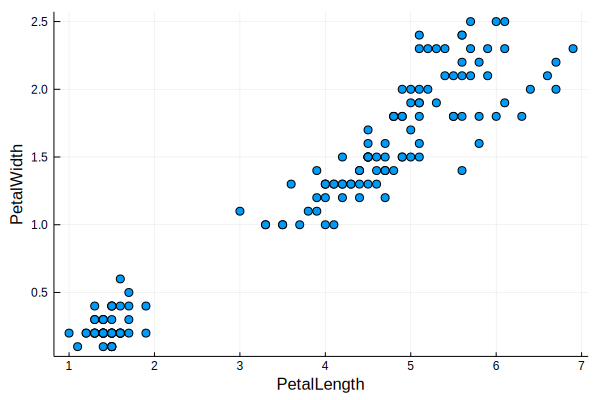

In [7]:
X = reduce(hcat, [df[:,:PetalLengthCm], df[:,:PetalWidthCm], 
        df[:,:SepalLengthCm], df[:,:SepalWidthCm]]);
scatter(X[:,1], X[:,2], 
    legend=false, xlabel="PetalLength", ylabel="PetalWidth")

We run the $k$-means algorithm with $k=2$ clusters. 

In [8]:
assign = mmids_kmeans(X, 2);

G = sum(dist .^ 2) = 552.0703091836734
G = sum(dist .^ 2) = 155.20167273184995
G = sum(dist .^ 2) = 152.53336910043723
G = sum(dist .^ 2) = 152.36870647733903
G = sum(dist .^ 2) = 152.36870647733903
G = sum(dist .^ 2) = 152.36870647733903
G = sum(dist .^ 2) = 152.36870647733903
G = sum(dist .^ 2) = 152.36870647733903
G = sum(dist .^ 2) = 152.36870647733903
G = sum(dist .^ 2) = 152.36870647733903


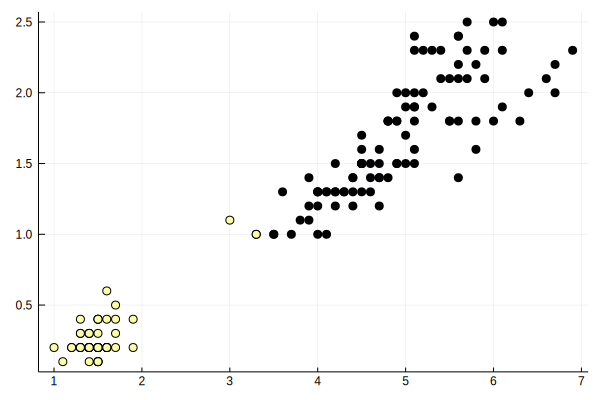

In [9]:
scatter(X[:,1], X[:,2], marker_z=assign, legend=false)

This clustering may seem less than perfect. But recall that (1) in this plot we are looking at only two of the four variables while $k$-means uses all of them, (2) we are not guaranteed to find the best solution, (3) our objective function is somewhat arbitrary, and (4) it is not clear what the right choice of $k$ is. In fact, the original dataset provided the correct answer as determined by a [botanist](https://en.wikipedia.org/wiki/Edgar_Anderson). Despite what the figure above may lead us to believe, there are in reality three separate species. So let's try with $k=3$ clusters.

In [10]:
assign = mmids_kmeans(X, 3; maxiter=20);

G = sum(dist .^ 2) = 546.7305280083422
G = sum(dist .^ 2) = 101.86656607317371
G = sum(dist .^ 2) = 87.00356562736206
G = sum(dist .^ 2) = 84.80172984452895
G = sum(dist .^ 2) = 84.10217888865148
G = sum(dist .^ 2) = 83.13638186876973
G = sum(dist .^ 2) = 81.8390020677262
G = sum(dist .^ 2) = 80.895776
G = sum(dist .^ 2) = 79.96297983461302
G = sum(dist .^ 2) = 79.43376414532675
G = sum(dist .^ 2) = 79.01070972222222
G = sum(dist .^ 2) = 78.94506582597728
G = sum(dist .^ 2) = 78.94506582597728
G = sum(dist .^ 2) = 78.94506582597728
G = sum(dist .^ 2) = 78.94506582597728
G = sum(dist .^ 2) = 78.94506582597728
G = sum(dist .^ 2) = 78.94506582597728
G = sum(dist .^ 2) = 78.94506582597728
G = sum(dist .^ 2) = 78.94506582597728
G = sum(dist .^ 2) = 78.94506582597728


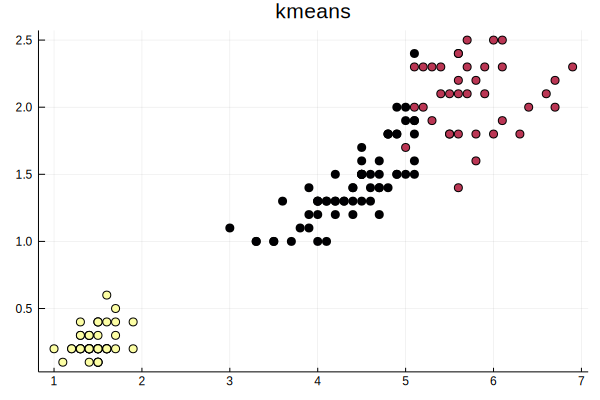

In [11]:
p3clust = scatter(X[:,1], X[:,2], 
    marker_z=assign, legend=false, title="kmeans")

Let's load the truth and compare.

In [12]:
df_truth = CSV.read("./iris-species.csv")
first(df_truth, 5)

,Id,Species
,Int64,String
1,1,Iris-setosa
2,2,Iris-setosa
3,3,Iris-setosa
4,4,Iris-setosa
5,5,Iris-setosa


The species are:

In [13]:
species = df_truth[:,:Species]
unique(species)

3-element Array{String,1}:
 "Iris-setosa"    
 "Iris-versicolor"
 "Iris-virginica" 

To plot the outcome, we rename the species arbitrarily as $1$, $2$, and $3$ using a [dictionary](https://docs.julialang.org/en/v1/base/collections/#Dictionaries-1).

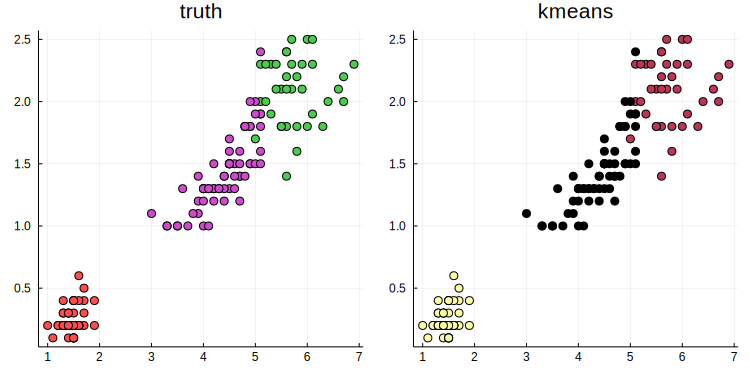

In [14]:
species2number = Dict("Iris-setosa"=>1, "Iris-versicolor"=>2, "Iris-virginica"=>3)
truth = map(i -> get(species2number,i,0), species)
ptruth = scatter(X[:,1], X[:,2], 
    marker_z=assign, legend=false, seriescolor=:lightrainbow, title="truth")
plot(ptruth, p3clust, layout=(1,2), size=(750,375))

This time we get a perfect outcome...

Out of curiosity, let's see what happens if we run $k$-means with $k=5$ clusters.

G = sum(dist .^ 2) = 514.9849601491834
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN
G = sum(dist .^ 2) = NaN


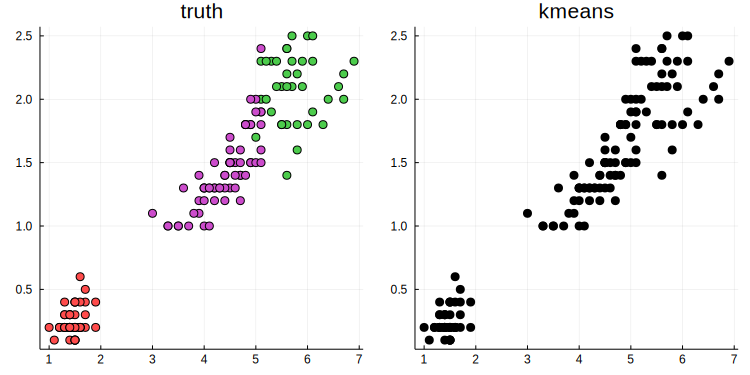

In [15]:
assign = mmids_kmeans(X, 5; maxiter=20)
p5clust = scatter(X[:,1], X[:,2], 
    marker_z=assign, legend=false, title="kmeans")
plot(ptruth, p5clust, layout=(1,2), size=(750,375))

*Exercise:* What happened? $\lhd$

Determining the appropriate number of clusters is not a straighforward problem. To quote [Wikipedia](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set):

> The correct choice of $k$ is often ambiguous, with interpretations depending on the shape and scale of the distribution of points in a data set and the desired clustering resolution of the user. In addition, increasing $k$ without penalty will always reduce the amount of error in the resulting clustering, to the extreme case of zero error if each data point is considered its own cluster (i.e., when $k$ equals the number of data points, $n$). Intuitively then, the optimal choice of $k$ will strike a balance between maximum compression of the data using a single cluster, and maximum accuracy by assigning each data point to its own cluster. If an appropriate value of $k$ is not apparent from prior knowledge of the properties of the data set, it must be chosen somehow. There are several categories of methods for making this decision.


In practice, [several heuristic approaches](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set) are in use. Note also that other approaches to clustering, e.g. [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) and [hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering), do not require a number of clusters as input. 

## 2 Document topic discovery

As a second example, we'll look at a more high-dimensional dataset. This one is from the [VMLS](http://vmls-book.stanford.edu/) textbook. You have to install the VMLS.jl package first. For this, use the command

    Pkg.add(PackageSpec(url="https://github.com/VMLS-book/VMLS.jl"))

In [16]:
using VMLS: wikipedia_data

Quoting [VMLS, Section 4.4.2]:

> We start with a corpus of N = 500 Wikipedia articles, compiled from weekly lists of the most popular articles between September 6, 2015, and June 11, 2016. We remove the section titles and reference sections (bibliography, notes, references, further reading), and convert each document to a list of words. The conversion removes numbers and stop words, and applies a stemming algorithm to nouns and verbs. We then form a dictionary of all the words that appear in at least 20 documents. This results in a dictionary of 4423 words. Each document in the corpus is represented by a word histogram vector of length 4423.

Our goal is to identify the broad topics covered in these documents by grouping them according to similarity in word count histogram.

In [17]:
articles, dictionary, titles = wikipedia_data();

Here are the first few entries of `dictionary` and `titles`.

In [18]:
dictionary[1:5]

5-element Array{String,1}:
 "lead"    
 "receive" 
 "play"    
 "american"
 "release" 

In [19]:
titles[1:5]

5-element Array{String,1}:
 "Unfinished_portrait_of_Franklin_D._Roosevelt"
 "Negan"                                       
 "Cam_Newton"                                  
 "Beyonce"                                     
 "Coachella_Valley_Music_and_Arts_Festival"    

The [term-document matrix](https://en.wikipedia.org/wiki/Document-term_matrix) `articles` is stored as an array of $500$ vectors of length $4423$. As we have done before, we will transform it into a matrix, where the rows are the documents (samples) and the columns are the words (features).

In [20]:
X = reduce(hcat,articles)'

500×4423 Adjoint{Float64,Array{Float64,2}}:
 0.0          0.0          0.0          …  0.0  0.0  0.0          0.0
 0.00511364   0.0          0.00113636      0.0  0.0  0.0          0.0
 0.0119136    0.0018615    0.00893522      0.0  0.0  0.0          0.0
 0.00273889   0.00547778   0.00213025      0.0  0.0  0.0          0.0
 0.00251731   0.00251731   0.00251731      0.0  0.0  0.00566394   0.0
 0.000937207  0.00374883   0.00374883   …  0.0  0.0  0.0          0.0
 0.00433369   0.00541712   0.0130011       0.0  0.0  0.0          0.0
 0.00114943   0.00114943   0.00114943      0.0  0.0  0.0          0.0
 0.0119048    0.00396825   0.00396825      0.0  0.0  0.0          0.0
 0.00197239   0.00197239   0.0             0.0  0.0  0.0          0.0
 0.00340136   0.00340136   0.00340136   …  0.0  0.0  0.0          0.0
 0.00182899   0.00228624   0.00137174      0.0  0.0  0.0          0.0
 0.00209644   0.0          0.00209644      0.0  0.0  0.0          0.0
 ⋮                                      ⋱     

To give a specific example of what this dataset contains, let's look at the first article. Its title is

In [21]:
titles[1]

"Unfinished_portrait_of_Franklin_D._Roosevelt"

It contains the following words (among the 4423 possibilities)

In [22]:
dictionary[findall(!iszero, articles[1])] # !iszero return true when an entry is not zero

82-element Array{String,1}:
 "united"       
 "base"         
 "former"       
 "week"         
 "tell"         
 "plan"         
 "original"     
 "attend"       
 "friend"       
 "decide"       
 "house"        
 "president"    
 "white"        
 ⋮              
 "painting"     
 "warm"         
 "portal"       
 "unconscious"  
 "counterpart"  
 "retreat"      
 "consciousness"
 "bedroom"      
 "remarkable"   
 "roosevelt"    
 "lucy"         
 "painter"      

The frequency of those words in this document is 

In [23]:
articles[1][findall(!iszero, articles[1])]

82-element Array{Float64,1}:
 0.00757576
 0.0151515 
 0.00757576
 0.00757576
 0.00757576
 0.00757576
 0.0151515 
 0.00757576
 0.00757576
 0.00757576
 0.0227273 
 0.0454545 
 0.0227273 
 ⋮         
 0.0227273 
 0.0227273 
 0.0151515 
 0.00757576
 0.00757576
 0.0151515 
 0.00757576
 0.00757576
 0.00757576
 0.0530303 
 0.00757576
 0.00757576

Note that if you do not know what a Julia function does, you can always ask for help.

In [24]:
?findall

search: findall findmax! findmax findlast



```
findall(f::Function, A)
```

Return a vector `I` of the indices or keys of `A` where `f(A[I])` returns `true`. If there are no such elements of `A`, return an empty array.

Indices or keys are of the same type as those returned by [`keys(A)`](@ref) and [`pairs(A)`](@ref).

# Examples

```jldoctest
julia> x = [1, 3, 4]
3-element Array{Int64,1}:
 1
 3
 4

julia> findall(isodd, x)
2-element Array{Int64,1}:
 1
 2

julia> A = [1 2 0; 3 4 0]
2×3 Array{Int64,2}:
 1  2  0
 3  4  0
julia> findall(isodd, A)
2-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 1)
 CartesianIndex(2, 1)

julia> findall(!iszero, A)
4-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 1)
 CartesianIndex(2, 1)
 CartesianIndex(1, 2)
 CartesianIndex(2, 2)

julia> d = Dict(:A => 10, :B => -1, :C => 0)
Dict{Symbol,Int64} with 3 entries:
  :A => 10
  :B => -1
  :C => 0

julia> findall(x -> x >= 0, d)
2-element Array{Symbol,1}:
 :A
 :C

```

---

```
findall(A)
```

Return a vector `I` of the `true` indices or keys of `A`. If there are no such elements of `A`, return an empty array. To search for other kinds of values, pass a predicate as the first argument.

Indices or keys are of the same type as those returned by [`keys(A)`](@ref) and [`pairs(A)`](@ref).

# Examples

```jldoctest
julia> A = [true, false, false, true]
4-element Array{Bool,1}:
 1
 0
 0
 1

julia> findall(A)
2-element Array{Int64,1}:
 1
 4

julia> A = [true false; false true]
2×2 Array{Bool,2}:
 1  0
 0  1

julia> findall(A)
2-element Array{CartesianIndex{2},1}:
 CartesianIndex(1, 1)
 CartesianIndex(2, 2)

julia> findall(falses(3))
0-element Array{Int64,1}
```

---

```
findall(
    pattern::Union{AbstractString,Regex},
    string::AbstractString;
    overlap::Bool = false,
)
```

Return a `Vector{UnitRange{Int}}` of all the matches for `pattern` in `string`. Each element of the returned vector is a range of indices where the matching sequence is found, like the return value of [`findnext`](@ref).

If `overlap=true`, the matching sequences are allowed to overlap indices in the original string, otherwise they must be from disjoint character ranges.


As suggested in [VMLS], we run $k$-means with $k=9$.

In [25]:
k = 9
assign = mmids_kmeans(X, k; maxiter=20);

G = sum(dist .^ 2) = 4.145094289456787
G = sum(dist .^ 2) = 3.889067221550393
G = sum(dist .^ 2) = 3.6537653592314046
G = sum(dist .^ 2) = 3.5769055180964853
G = sum(dist .^ 2) = 3.539279638156878
G = sum(dist .^ 2) = 3.5306142229591364
G = sum(dist .^ 2) = 3.525694231773985
G = sum(dist .^ 2) = 3.5240777197402506
G = sum(dist .^ 2) = 3.521941947123763
G = sum(dist .^ 2) = 3.521556271890825
G = sum(dist .^ 2) = 3.521156208798304
G = sum(dist .^ 2) = 3.5199090584043637
G = sum(dist .^ 2) = 3.518978586357943
G = sum(dist .^ 2) = 3.513498541485085
G = sum(dist .^ 2) = 3.5054257249068175
G = sum(dist .^ 2) = 3.4901036529302654
G = sum(dist .^ 2) = 3.4668496585203354
G = sum(dist .^ 2) = 3.4591749847181035
G = sum(dist .^ 2) = 3.4591749847181035
G = sum(dist .^ 2) = 3.4591749847181035


To get a sense of what the clustering is, we use the following code from the [VMLS Julia Companion](http://vmls-book.stanford.edu/vmls-julia-companion.pdf) which summarizes it.

In [26]:
n, d = size(X)
reps = opt_reps(X, k, assign) # recompute representatives
dist = [norm(X[i,:] .- reps[assign[i],:]) for i=1:n] # recompute distances to reps
for j = 1:k
    in_j = [i for i=1:n if assign[i] == j]
    println()
    println("Cluster ", j, " (", length(in_j), " articles)")
    I = sortperm(reps[j,:], rev=true)
    println("Top words: \n    ", dictionary[I[1:5]]);
    println("Documents closest to representative: ")
    I = sortperm(dist[in_j])
    for i= 1:5
        println("    ", titles[in_j[I[i]]])
    end 
end


Cluster 1 (43 articles)
Top words: 
    ["season", "team", "game", "win", "play"]
Documents closest to representative: 
    Kobe_Bryant
    Lamar_Odom
    Johan_Cruyff
    Jose_Mourinho
    Yogi_Berra

Cluster 2 (189 articles)
Top words: 
    ["united", "president", "party", "family", "government"]
Documents closest to representative: 
    Mahatma_Gandhi
    Carly_Fiorina
    Sigmund_Freud
    Marco_Rubio
    Frederick_Douglass

Cluster 3 (36 articles)
Top words: 
    ["series", "season", "episode", "character", "film"]
Documents closest to representative: 
    The_X-Files
    Game_of_Thrones
    House_of_Cards_(U.S._TV_series)
    Daredevil_(TV_series)
    Supergirl_(U.S._TV_series)

Cluster 4 (45 articles)
Top words: 
    ["album", "release", "song", "music", "single"]
Documents closest to representative: 
    David_Bowie
    Kanye_West
    Celine_Dion
    Kesha
    Ariana_Grande

Cluster 5 (21 articles)
Top words: 
    ["fight", "win", "event", "champion", "fighter"]
Documents clos

## 3 Using JuliaStats/Clustering.jl

The $k$-means algorithm is implemented in the [Clustering.jl](https://juliastats.org/Clustering.jl/latest/kmeans.html) package. We briefly show how to use it here on the iris dataset, based on this [example](https://juliastats.org/Clustering.jl/latest/kmeans.html#Examples-1). We reload the data first.

In [27]:
using Clustering

In [28]:
df = CSV.read("./iris-measurements.csv")
sep_l, sep_w = df[:,:SepalLengthCm], df[:,:SepalWidthCm]
pet_l, pet_w = df[:,:PetalLengthCm], df[:,:PetalWidthCm]
X = reduce(hcat, [pet_l, pet_w, sep_l, sep_w])
df_truth = CSV.read("./iris-species.csv")
species = df_truth[:,:Species];
species2number = Dict("Iris-setosa"=>1, "Iris-versicolor"=>2, "Iris-virginica"=>3)
truth = map(i -> get(species2number,i,0), species);

In [29]:
R = kmeans(X', 3); # the required input is a d x n matrix, so we transpose

The output is a special [type](https://docs.julialang.org/en/v1/manual/types/index.html):

```Julia
struct KmeansResult{C<:AbstractMatrix{<:AbstractFloat},
                            D<:Real,WC<:Real} <: ClusteringResult
    centers::C                 # cluster centers (d x k)
    assignments::Vector{Int}   # assignments (n)
    costs::Vector{D}           # cost of the assignments (n)
    counts::Vector{Int}        # number of points assigned to each cluster (k)
    wcounts::Vector{WC}        # cluster weights (k)
    totalcost::D               # total cost (i.e. objective)
    iterations::Int            # number of elapsed iterations
    converged::Bool            # whether the procedure converged
end
```

In [30]:
a = R.assignments; # get the assignments of points to clusters
c = R.counts; # get the cluster sizes
M = R.centers; # get the cluster centers

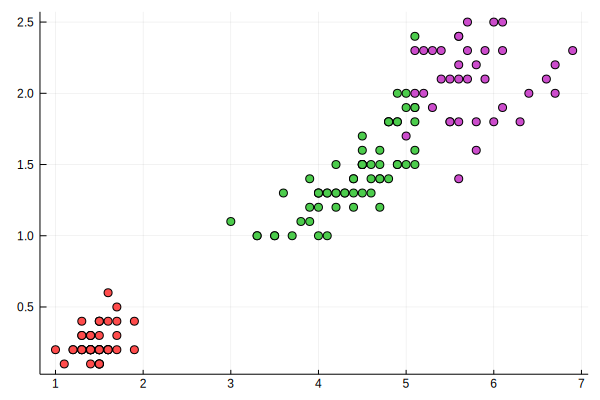

In [31]:
scatter(df.PetalLengthCm, df.PetalWidthCm, marker_z=R.assignments,
    color=:lightrainbow, legend=false)

You can compute a [contingency matrix](https://scikit-learn.org/stable/modules/clustering.html#contingency-matrix) to evalutate your clustering results, if you have access to the truth.

In [32]:
counts(R,truth)

3×3 Array{Int64,2}:
  0   3  36
  0  47  14
 50   0   0

You can also try other clustering algorithms, e.g. [DBSCAN](https://juliastats.org/Clustering.jl/latest/dbscan.html).

In [33]:
dbscanR = dbscan(X', 1);

In [34]:
dbscanAssign = zeros(Int, size(X,1))
for i=1:length(dbscanR)
    dbscanAssign[dbscanR[i].core_indices] .= i
end

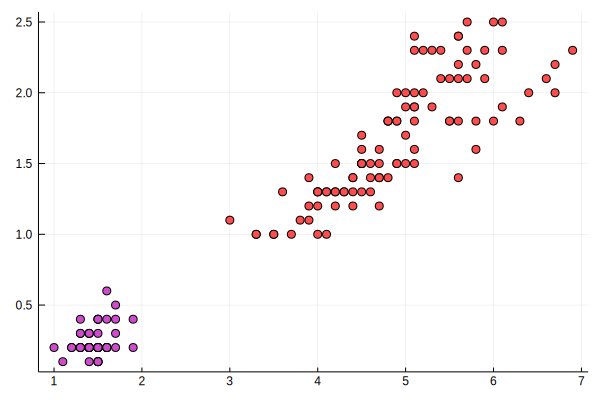

In [35]:
scatter(df.PetalLengthCm, df.PetalWidthCm, marker_z=dbscanAssign,
    color=:lightrainbow, legend=false)

DBSCAN works particularly well on non-linearly separable problems like this one:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/DBSCAN-density-data.svg/500px-DBSCAN-density-data.svg.png)

([Source: Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#/media/File:DBSCAN-density-data.svg))